In [ ]:
# BASE
import numpy as np
import pandas as pd
import math
import scipy

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import panel as pn
pn.extension("tabulator")
import plotly.express as px
import statsmodels.api as sm

In [ ]:
def get_csv(name, secondary=True):
  if secondary:
    full_path = 'secondary_data/%s.csv' % name
  else:
    full_path = '../data_scraping/%s.csv' % name
  print('Reading', full_path)
  return pd.read_csv(full_path, encoding='unicode_escape')

# Read all datasets
property_sales = get_csv('property_sales', secondary=False)
immigrants = get_csv('Immigrants(thousand)')
private_households = get_csv('Private households')
persons_private_households = get_csv('Persons in private households')
household_values = get_csv('Household debt, loans and debt securities (Percent of GDP).xls - HH_LS').T.reset_index()
gdp_growth = get_csv('Real GDP growth (Annual percent change).xls - NGDP_RPCH').T.reset_index()
gdp_values = get_csv('GDP per capita, current prices (Purchasing power parity; international dollars per capita).xls - PPPPC').T.reset_index()
population = get_csv('Population (Millions of people).xls - LP').T.reset_index()
infliation = get_csv('Inflation rate, average consumer prices (Annual percent change).xls - PCPIPCH').T.reset_index()
unemployment = get_csv('Unemployment rate (Percent).xls - LUR').T.reset_index()

Reading /drive/My Drive/Burak data/property_sales.csv
Reading /drive/My Drive/Burak data/Immigrants(thousand).csv
Reading /drive/My Drive/Burak data/Private households.csv
Reading /drive/My Drive/Burak data/Persons in private households.csv
Reading /drive/My Drive/Burak data/Household debt, loans and debt securities (Percent of GDP).xls - HH_LS.csv
Reading /drive/My Drive/Burak data/Real GDP growth (Annual percent change).xls - NGDP_RPCH.csv
Reading /drive/My Drive/Burak data/GDP per capita, current prices (Purchasing power parity; international dollars per capita).xls - PPPPC.csv
Reading /drive/My Drive/Burak data/Population (Millions of people).xls - LP.csv
Reading /drive/My Drive/Burak data/Inflation rate, average consumer prices (Annual percent change).xls - PCPIPCH.csv
Reading /drive/My Drive/Burak data/Unemployment rate (Percent).xls - LUR.csv


In [ ]:
# Prints a short analysis for dataset and its columns
def dataset_analysis(df):
  print('Dataset Shape:', df.shape)
  print('Dataset number of null values:', df.isnull().sum().sum())
  print('Dataset Columns:')
  for col in df.columns:
    is_numeric = str(df[col].dtype) in ['float64', 'int64']
    if is_numeric:
      values_str = 'Min: %.1f, Mean: %.1f, Max: %.1f' % (df[col].min(), df[col].mean(), df[col].max())
    else:
      values_str = 'Values: %s' % str(df[col].unique())
    print('\tColumn: %s, %s, %s' % (col, 'Numeric' if is_numeric else 'Not Numeric', values_str))

In [ ]:
# Counties in scope
COUNTIES = ['Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin', 'Galway',
            'Kerry', 'Kildare', 'Kilkenny', 'Laois', 'Leitrim', 'Limerick',
            'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly',
            'Roscommon', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
            'Wexford', 'Wicklow']

## Propety Sales Dataset

In [ ]:
dataset_analysis(property_sales)
property_sales.sample(10)

Dataset Shape: (612233, 6)
Dataset number of null values: 0
Dataset Columns:
	Column: Unnamed: 0, Numeric, Min: 0.0, Mean: 306116.0, Max: 612232.0
	Column: Full Date, Not Numeric, Values: ['23/12/2010' '22/12/2010' '21/12/2010' ... '06/02/2023' '17/06/2023'
 '25/03/2023']
	Column: Year, Numeric, Min: 2010.0, Mean: 2017.5, Max: 2023.0
	Column: County, Not Numeric, Values: ['Carlow' 'Cavan' 'Clare' 'Cork' 'Donegal' 'Dublin' 'Galway' 'Kerry'
 'Kildare' 'Kilkenny' 'Laois' 'Leitrim' 'Limerick' 'Longford' 'Louth'
 'Mayo' 'Meath' 'Monaghan' 'Offaly' 'Roscommon' 'Sligo' 'Tipperary'
 'Waterford' 'Westmeath' 'Wexford' 'Wicklow']
	Column: Price, Numeric, Min: 5001.0, Mean: 283461.4, Max: 182378854.0
	Column: Full Address, Not Numeric, Values: ['108 Browneshill Wood, Browneshill Road, Carlow, Carlow'
 '41 Gort Na Greine, Ballinabranna, Carlow'
 '84 Sandhills, Hacketstown Road, Carlow' ...
 '12 PUTLAND VILLAS, VEVAY RD, BRAY, A98X7Y0</a'
 '33 LA VALLEE, UPPER DARGLE RD, FASSAROE, A98X971</a'
 'SCHO

Unnamed: 0   Full Date  Year   County   Price  \
200017      200017  25/11/2016  2016   Dublin  595000   
251793      251793  04/10/2017  2017   Dublin  426950   
454694      454694  27/03/2020  2020  Wexford  130000   
26165        26165  01/11/2011  2011   Dublin  127500   
121810      121810  10/09/2014  2014  Kildare  230000   
558105      558105  26/01/2022  2022    Louth  251057   
538629      538629  11/04/2022  2022   Dublin  807500   
420410      420410  13/11/2020  2020   Dublin  445500   
154210      154210  21/08/2015  2015   Dublin  350000   
39050        39050  21/09/2011  2011  Wicklow  245000   

                                             Full Address  
200017        Laburnum Cottage, Kilgobbin Road, Sandyford  
251793  58 SMITHFIELD VILLAGE, BOWE ST, DUBLIN 7, Dubl...  
454694               126 MOUNT PROSPECT, CLONARD, WEXFORD  
26165    25 East Courtyard, Tullyvale, Cabinteely, Dublin  
121810           12 THORNHILL MEADOWS, CELBRIDGE, KILDARE  
558105                 175 Dundoogan, Haynestown, Dundalk  
538629  1 ST ANTHONYS RATHMICHAEL, FERNDALE GLEN, RATH...  
420410       84 QUINNS RD, SHANKILL, DUBLIN 18, Dublin 18  
154210  65 PEMBROKE COTTAGES, DONNYBROOK, DUBLIN 4, Du...  
39050                35 Glebemount, Wicklow Town, Wicklow

In [ ]:
# According to month part of the full date, create a quarter number column
property_sales['QuarterNumber'] = property_sales.apply(lambda row: int((int(row['Full Date'].split('/')[1])+2)//3), axis=1)

# Format Year and QuarterNumber columns in Year-Qurter format
property_sales['Quarter'] = property_sales.apply(lambda row: '%d-Q%d' % (int(row['Year']), int(row['QuarterNumber'])), axis=1)

property_sales.sample(5)

Unnamed: 0   Full Date  Year     County   Price  \
41609        41609  24/10/2012  2012       Cork  232500   
132748      132748  24/11/2014  2014  Tipperary   85000   
32528        32528  27/05/2011  2011    Kildare  485000   
82679        82679  16/08/2013  2013      Kerry   72000   
194582      194582  16/03/2016  2016       Cork  251000   

                                             Full Address  QuarterNumber  \
41609                     15 Ashbrook, Castlepark, Mallow              4   
132748         20 BLACKTHORN WALK, MULLINOLY, MULLINAHONE              4   
32528   3 Canning Place, Newbridge, County Kildare, Ki...              2   
82679                        17 COIS ARD, DUAGH, LISTOWEL              3   
194582             2 DRYDEN TERRACE, BALLINLOUGH RD, CORK              1   

        Quarter  
41609   2012-Q4  
132748  2014-Q4  
32528   2011-Q2  
82679   2013-Q3  
194582  2016-Q1

In [ ]:
# Drop columns that won't be grouped
property_sales = property_sales.drop(['Unnamed: 0', 'Full Date', 'Year', 'QuarterNumber', 'Full Address'], axis=1)

# Creates a percentile aggregation function
def percentile(percent):
  return lambda row: row.quantile(percent / 100)

# Aggregate all sales in a County in that quarter
property_sales = property_sales.groupby(['Quarter', 'County']).aggregate(['count', 'min', 'mean', 'max', 'median', percentile(25), percentile(75), percentile(90)])

# Reset grouped columns into columns again
property_sales = property_sales.reset_index()

# Remove multi index
property_sales.columns = ['_'.join([c for c in col_names if len(c) > 0]) for col_names in property_sales.columns.values]

# Rename percentile columns
property_sales = property_sales.rename(columns={
    'Price_count': 'SaleCount',
    'Price_<lambda_0>': 'Price_25p',
    'Price_<lambda_1>': 'Price_75p',
    'Price_<lambda_2>': 'Price_90p',
})

property_sales.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
566   2015-Q2      Sligo        188       7000  115183.106383     410000   
296   2012-Q4      Laois        157      13500   87150.350318     308370   
895   2018-Q3    Leitrim         84      20000  114267.500000     297500   
573   2015-Q3      Cavan        171      15000  106415.245614    2050000   
1115  2020-Q3  Westmeath        199      20000  192858.577889     920000   

      Price_median  Price_25p  Price_75p  Price_90p  
566       101000.0   49375.00  155514.75   220907.5  
296        73500.0   45000.00  110000.00   165960.0  
895        95750.0   67519.75  148250.00   222000.0  
573        85000.0   52931.50  120000.00   165000.0  
1115      167000.0  118750.00  243645.00   336000.0

## Immigration Dataset

In [ ]:
dataset_analysis(immigrants)
immigrants.sample(10)

Dataset Shape: (14, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿STATISTIC Label, Not Numeric, Values: ['Annual Population Change']
	Column: Year, Numeric, Min: 2010.0, Mean: 2016.5, Max: 2023.0
	Column: Component, Not Numeric, Values: ['Immigrants']
	Column: UNIT, Not Numeric, Values: ['Thousand']
	Column: VALUE, Numeric, Min: 41.8, Mean: 82.0, Max: 141.6


ï»¿STATISTIC Label  Year   Component      UNIT  VALUE
3   Annual Population Change  2013  Immigrants  Thousand   62.7
7   Annual Population Change  2017  Immigrants  Thousand   95.3
9   Annual Population Change  2019  Immigrants  Thousand   97.1
1   Annual Population Change  2011  Immigrants  Thousand   53.3
10  Annual Population Change  2020  Immigrants  Thousand   95.6
0   Annual Population Change  2010  Immigrants  Thousand   41.8
12  Annual Population Change  2022  Immigrants  Thousand  107.8
8   Annual Population Change  2018  Immigrants  Thousand   96.0
5   Annual Population Change  2015  Immigrants  Thousand   75.9
6   Annual Population Change  2016  Immigrants  Thousand   82.3

In [ ]:
# We only need Year and Immigrant value from this dataset
# Since unit is Thousand, multiplying value by 1000, and making Year column as index
immigrants = immigrants[['VALUE', 'Year']]
immigrants['VALUE'] = immigrants['VALUE'] * 1000
immigrants.sample(5)

<ipython-input-10-743ecf868a2d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immigrants['VALUE'] = immigrants['VALUE'] * 1000


VALUE  Year
7   95300.0  2017
9   97100.0  2019
4   66500.0  2014
3   62700.0  2013
10  95600.0  2020

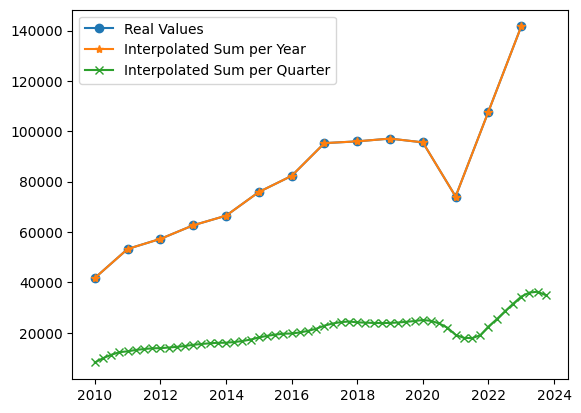

In [ ]:
x = immigrants['Year'].astype(float)
y = immigrants['VALUE'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y), interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(x, fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
immigrants = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE': fixed_quarter_y,
})

immigrants.sample(5)

Quarter         VALUE
24  2016-Q1  19744.558752
36  2019-Q1  23943.486039
26  2016-Q3  20778.408714
41  2020-Q2  24757.114878
55  2023-Q4  34947.849970

## Private Households dataset

In [ ]:
dataset_analysis(private_households)
private_households.sample(10)

Dataset Shape: (93, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿"Statistic Label", Not Numeric, Values: ['Private households']
	Column: CensusYear, Numeric, Min: 2011.0, Mean: 2016.3, Max: 2022.0
	Column: County and City, Not Numeric, Values: ['State' 'Carlow' 'Dublin City' 'DÃºn Laoghaire-Rathdown' 'Fingal'
 'South Dublin' 'Kildare' 'Kilkenny' 'Laois' 'Longford' 'Louth' 'Meath'
 'Offaly' 'Westmeath' 'Wexford' 'Wicklow' 'Clare'
 'Cork City and Cork County' 'Kerry' 'Limerick City and County'
 'Tipperary' 'Waterford City and County' 'Galway City' 'Galway County'
 'Leitrim' 'Mayo' 'Roscommon' 'Sligo' 'Cavan' 'Donegal' 'Monaghan']
	Column: UNIT, Not Numeric, Values: ['Number']
	Column: VALUE, Numeric, Min: 12308.0, Mean: 111777.4, Max: 1841152.0


ï»¿"Statistic Label"  CensusYear County and City    UNIT  VALUE
6    Private households        2011         Kildare  Number  70763
23   Private households        2011   Galway County  Number  60952
37   Private households        2016         Kildare  Number  73596
16   Private households        2011           Clare  Number  42648
60   Private households        2016         Donegal  Number  58505
82   Private households        2022       Tipperary  Number  62232
55   Private households        2016         Leitrim  Number  12452
57   Private households        2016       Roscommon  Number  24013
26   Private households        2011       Roscommon  Number  23672
28   Private households        2011           Cavan  Number  25818

In [ ]:
# We analyse by county, so removing cities from this dataset
private_households['County and City'] = private_households['County and City'].apply(lambda value: {
    'Cork City and Cork County': 'Cork',
    'Dublin City': 'Dublin',
    'DÃºn Laoghaire-Rathdown': 'Dublin',
    'Galway City': 'Galway',
    'Limerick City and County': 'Limerick',
    'South Dublin': 'Dublin',
    'Waterford City and County': 'Waterford'
}.get(value, value))

# Filter down for counties in scope
private_households = private_households[private_households['County and City'].isin(COUNTIES)]

# Rename columns
private_households = private_households.rename(columns={
    'CensusYear': 'Year',
    'County and City': 'County',
})

private_households = private_households[['County', 'Year', 'VALUE']]
private_households = private_households.groupby(['County', 'Year']).agg(VALUE=('VALUE', 'sum')).reset_index()

private_households.sample(5)

County  Year  VALUE
24    Kildare  2011  70763
55     Offaly  2016  27343
19     Galway  2016  28859
69  Westmeath  2011  30739
51   Monaghan  2011  21264

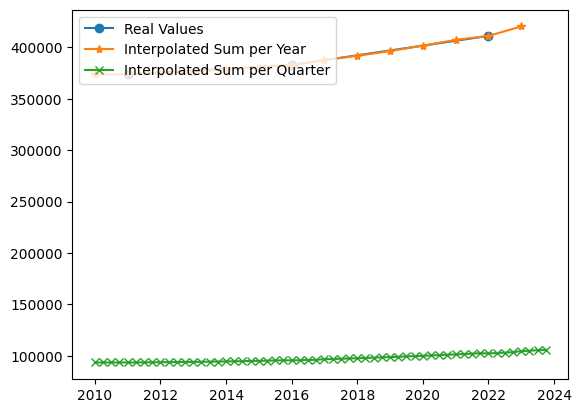

In [ ]:
def interpolate_private_households(county, show_plot=False):
  county_private_households = private_households[private_households['County'] == county]

  x = county_private_households['Year'].astype(float)
  y = county_private_households['VALUE'].astype(float)
  interpolater = scipy.interpolate.CubicSpline(x, y / 4)

  per_quarter_x = [y + q/4 for y in range(2010, 2024) for q in range(4)]
  per_quarter_y = [float(interpolater(pmx)) for pmx in per_quarter_x]

  interpolated_year = [sum(per_quarter_y[i:i+4]) for i in range(0, len(per_quarter_y), 4)]
  interpolate_ratio = [list(y)[(i-1)//5] / interpolated_value if i in [1, 6, 12] else 1 for i, interpolated_value in enumerate(interpolated_year)]

  fixed_per_quarter_y = [interpolate_ratio[i//4] * pqy for i, pqy in enumerate(per_quarter_y)]
  fixed_interpolated_year_x = [y for y in range(2010, 2024)]
  fixed_interpolated_year = [sum(fixed_per_quarter_y[i:i+4]) for i in range(0, len(fixed_per_quarter_y), 4)]

  if show_plot:
    plt.plot(x, y, '-o', label='Real Values')
    plt.plot(fixed_interpolated_year_x, fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
    plt.plot(per_quarter_x, fixed_per_quarter_y, '-x', label='Interpolated Sum per Quarter')
    plt.legend(loc="upper left")
    plt.show()

  return per_quarter_x, fixed_per_quarter_y

_ = interpolate_private_households('Dublin', show_plot=True)

In [ ]:
private_households_dict = {
    'County': [],
    'Quarter': [],
    'VALUE': [],
}

for cnty in COUNTIES:
  cx, cy = interpolate_private_households(cnty)
  private_households_dict['County'].extend([cnty for _ in cx])
  private_households_dict['Quarter'].extend(['%d-Q%d' % (y, q+1) for y in range(2010, 2024) for q in range(4)])
  private_households_dict['VALUE'].extend(cy)

private_households = pd.DataFrame(private_households_dict)
private_households.sample(5)

County  Quarter         VALUE
919       Meath  2015-Q4  16004.734138
1017     Offaly  2012-Q2   6709.143466
1102  Roscommon  2019-Q3   6243.092803
433       Kerry  2020-Q2  14232.814299
909       Meath  2013-Q2  15631.226562

## Persons in Private Households

In [ ]:
dataset_analysis(persons_private_households)
persons_private_households.sample(10)

Dataset Shape: (93, 5)
Dataset number of null values: 0
Dataset Columns:
	Column: ï»¿"Statistic Label", Not Numeric, Values: ['Persons in private households']
	Column: CensusYear, Numeric, Min: 2011.0, Mean: 2016.3, Max: 2022.0
	Column: County and City, Not Numeric, Values: ['State' 'Carlow' 'Dublin City' 'DÃºn Laoghaire-Rathdown' 'Fingal'
 'South Dublin' 'Kildare' 'Kilkenny' 'Laois' 'Longford' 'Louth' 'Meath'
 'Offaly' 'Westmeath' 'Wexford' 'Wicklow' 'Clare'
 'Cork City and Cork County' 'Kerry' 'Limerick City and County'
 'Tipperary' 'Waterford City and County' 'Galway City' 'Galway County'
 'Leitrim' 'Mayo' 'Roscommon' 'Sligo' 'Cavan' 'Donegal' 'Monaghan']
	Column: UNIT, Not Numeric, Values: ['Number']
	Column: VALUE, Numeric, Min: 31556.0, Mean: 306101.9, Max: 5046681.0


ï»¿"Statistic Label"  CensusYear County and City    UNIT   VALUE
55  Persons in private households        2016         Leitrim  Number   31721
25  Persons in private households        2011            Mayo  Number  128492
38  Persons in private households        2016        Kilkenny  Number   97536
22  Persons in private households        2011     Galway City  Number   70918
43  Persons in private households        2016          Offaly  Number   77755
84  Persons in private households        2022     Galway City  Number   80918
11  Persons in private households        2011           Meath  Number  184336
8   Persons in private households        2011           Laois  Number   79751
6   Persons in private households        2011         Kildare  Number  208522
32  Persons in private households        2016          Carlow  Number   56609

In [ ]:
# We analyse by county, so removing cities from this dataset
persons_private_households['County and City'] = persons_private_households['County and City'].apply(lambda value: {
    'Cork City and Cork County': 'Cork',
    'Dublin City': 'Dublin',
    'DÃºn Laoghaire-Rathdown': 'Dublin',
    'Galway City': 'Galway',
    'Limerick City and County': 'Limerick',
    'South Dublin': 'Dublin',
    'Waterford City and County': 'Waterford'
}.get(value, value))

# Filter down for counties in scope
persons_private_households = persons_private_households[persons_private_households['County and City'].isin(COUNTIES)]

# Rename columns
persons_private_households = persons_private_households.rename(columns={
    'CensusYear': 'Year',
    'County and City': 'County',
})

persons_private_households = persons_private_households[['County', 'Year', 'VALUE']]
persons_private_households = persons_private_households.groupby(['County', 'Year']).agg(VALUE=('VALUE', 'sum')).reset_index()

persons_private_households.sample(5)

County  Year   VALUE
33    Leitrim  2011   31556
49      Meath  2016  194400
6       Clare  2011  115587
64  Tipperary  2016  158933
5       Cavan  2022   80749

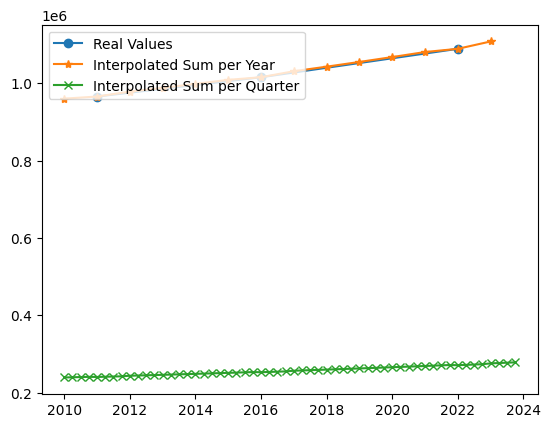

In [ ]:
def interpolate_persons_private_households(county, show_plot=False):
  county_persons_private_households = persons_private_households[persons_private_households['County'] == county]

  x = county_persons_private_households['Year'].astype(float)
  y = county_persons_private_households['VALUE'].astype(float)
  interpolater = scipy.interpolate.CubicSpline(x, y / 4)

  per_quarter_x = [y + q/4 for y in range(2010, 2024) for q in range(4)]
  per_quarter_y = [float(interpolater(pmx)) for pmx in per_quarter_x]

  interpolated_year = [sum(per_quarter_y[i:i+4]) for i in range(0, len(per_quarter_y), 4)]
  interpolate_ratio = [list(y)[(i-1)//5] / interpolated_value if i in [1, 6, 12] else 1 for i, interpolated_value in enumerate(interpolated_year)]

  fixed_per_quarter_y = [interpolate_ratio[i//4] * pqy for i, pqy in enumerate(per_quarter_y)]
  fixed_interpolated_year_x = [y for y in range(2010, 2024)]
  fixed_interpolated_year = [sum(fixed_per_quarter_y[i:i+4]) for i in range(0, len(fixed_per_quarter_y), 4)]

  if show_plot:
    plt.plot(x, y, '-o', label='Real Values')
    plt.plot(fixed_interpolated_year_x, fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
    plt.plot(per_quarter_x, fixed_per_quarter_y, '-x', label='Interpolated Sum per Quarter')
    plt.legend(loc="upper left")
    plt.show()

  return per_quarter_x, fixed_per_quarter_y

_ = interpolate_persons_private_households('Dublin', show_plot=True)

In [ ]:
persons_private_households_dict = {
    'County': [],
    'Quarter': [],
    'VALUE': [],
}

for cnty in COUNTIES:
  cx, cy = interpolate_persons_private_households(cnty)
  persons_private_households_dict['County'].extend([cnty for _ in cx])
  persons_private_households_dict['Quarter'].extend(['%d-Q%d' % (y, q+1) for y in range(2010, 2024) for q in range(4)])
  persons_private_households_dict['VALUE'].extend(cy)

persons_private_households = pd.DataFrame(persons_private_households_dict)
persons_private_households.sample(5)

County  Quarter         VALUE
805       Louth  2015-Q2  31684.046307
853        Mayo  2013-Q2  31848.500000
1138      Sligo  2014-Q3  15824.417614
1265  Waterford  2018-Q2  29359.395597
1219  Tipperary  2020-Q4  41076.110085

## Household debt, loans and debt security values

In [ ]:
dataset_analysis(household_values)
household_values.head()

Dataset Shape: (74, 5)
Dataset number of null values: 221
Dataset Columns:
	Column: index, Not Numeric, Values: ['Household debt, loans and debt securities (Percent of GDP)' '1950'
 '1951' '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960'
 '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970'
 '1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020'
 '2021' '2022']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 'no data' 51.3566376 58.25027305 69.72334394 81.05057955
 91.5734712 97.56634698 107.9222353 117.5626331 112.3034554 106.0115782
 98.10836204 92.81276295 80.39213676 55.7731504 52.74864363 46.67201768
 41.797931 37.51783687

index    0        1    2  \
0  Household debt, loans and debt securities (Per...  NaN  Ireland  NaN   
1                                               1950  NaN  no data  NaN   
2                                               1951  NaN  no data  NaN   
3                                               1952  NaN  no data  NaN   
4                                               1953  NaN  no data  NaN   

             3  
0  Â©IMF, 2023  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# Drop first row
household_values = household_values.drop(0)

# Column names
household_values.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
household_values = household_values[['Year', 'VALUE']]

# Filter down that has data
household_values = household_values[household_values['VALUE'] != 'no data']

# Change column type
household_values['Year'] = household_values['Year'].astype(int)
household_values['VALUE'] = household_values['VALUE'].astype(int)

household_values.sample(5)

Year  VALUE
60  2009    117
53  2002     51
57  2006     91
63  2012     98
58  2007     97

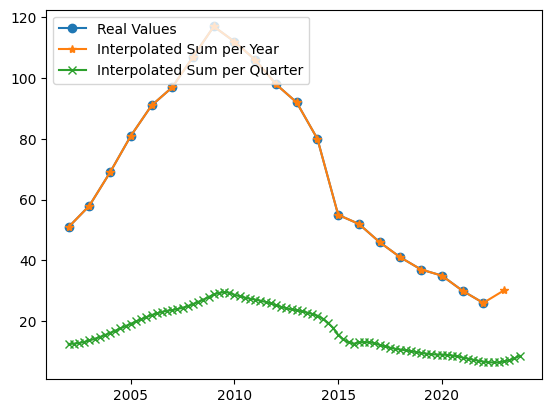

In [ ]:
x = household_values['Year'].astype(float)
y = household_values['VALUE'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)] + [2023 + i/12 for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)] + [2023 + i/4 for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x) + [2023], fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
household_values = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)] + ['2023-Q%d' % (i+1) for i in range(4)],
    'VALUE': fixed_quarter_y,
})

household_values.sample(5)

Quarter      VALUE
5   2003-Q2  14.174572
71  2019-Q4   9.017602
6   2003-Q3  14.760625
80  2022-Q1   6.681918
72  2020-Q1   9.001573

## GDP Growth

In [ ]:
dataset_analysis(gdp_growth)
gdp_growth.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Real GDP growth (Annual percent change)' '1980' '1981' '1982' '1983'
 '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013'
 '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023'
 '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 2.9 2.5 1.5 -0.7 3.2 1.9 0.4 3.6 3.0 5.6 7.7 1.6 2.3 5.9 9.6
 9.1 10.7 8.8 10.5 9.4 5.3 6.8 5.7 5.0 -4.5 -5.1 1.7 1.3 -0.1 1.2 24.5 1.8
 9.3 8.5 6.6 15.1 2.0 3.3 2.7]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


index    0        1    2            3
0  Real GDP growth (Annual percent change)  NaN  Ireland  NaN  Â©IMF, 2023
1                                     1980  NaN      2.9  NaN          NaN
2                                     1981  NaN      2.5  NaN          NaN
3                                     1982  NaN      1.5  NaN          NaN
4                                     1983  NaN     -0.7  NaN          NaN

In [ ]:
# Drop first row
gdp_growth = gdp_growth.drop(0)

# Column names
gdp_growth.columns = ['Year', 'empty1', 'VALUE0', 'empty2', 'empty3']

# Filter columns
gdp_growth = gdp_growth[['Year', 'VALUE0']]

# Change column type
gdp_growth['Year'] = gdp_growth['Year'].astype(int)
gdp_growth['VALUE0'] = gdp_growth['VALUE0'].astype(int)

gdp_growth.sample(5)

Year  VALUE0
31  2010       1
24  2003       3
33  2012       0
15  1994       5
20  1999      10

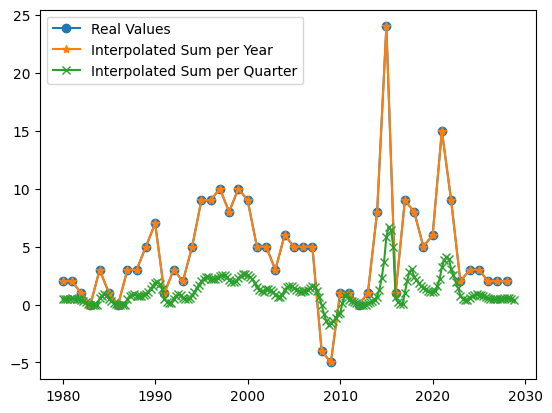

In [ ]:
x = gdp_growth['Year'].astype(float)
y = gdp_growth['VALUE0'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x), fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
gdp_growth = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE0': fixed_quarter_y,
})

gdp_growth.sample(5)

Quarter    VALUE0
5    1981-Q2  0.516887
195  2028-Q4  0.434884
38   1989-Q3  1.346134
128  2012-Q1  0.000000
32   1988-Q1  0.759766

In [ ]:
# Create list per quarter and value (assuming 1980 was 1000)
gdp_growth_based = []
last_based_value = 1000
for qy in fixed_quarter_y:
  gdp_growth_based.append(last_based_value)
  last_based_value += last_based_value * qy / 100

gdp_growth['VALUE1'] = gdp_growth_based
gdp_growth.sample(5)

Quarter    VALUE0       VALUE1
5    1981-Q2  0.516887  1025.479351
85   2001-Q2  1.259614  2551.060089
152  2018-Q1  2.411526  5001.467625
188  2027-Q1  0.478073  8448.240033
72   1998-Q1  2.093127  1924.839106

## GDP per capita with purchasing power parity

In [ ]:
dataset_analysis(gdp_values)
gdp_values.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['GDP per capita, current prices (Purchasing power parity; international dollars per capita)'
 '1980' '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989'
 '1990' '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020' '2021' '2022' '2023' '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 7362.645 8159.941 8701.151 8914.454 9464.638 9923.119 10164.11
 10776.764 11542.685 12745.298 14256.81 14896.37 15653.346 16305.232
 17577.013 19582.999 21605.842 24086.707 26215.161 29054.141 32040.558
 33968.414 35908.917 37111.456 39915.513 42492.628 44701.545 46998.295
 45032.601 42716.886 43756.065 45072.58 46230.701 47727.674 51132.925
 69057.156 71164.1

index    0         1    2  \
0  GDP per capita, current prices (Purchasing pow...  NaN   Ireland  NaN   
1                                               1980  NaN  7362.645  NaN   
2                                               1981  NaN  8159.941  NaN   
3                                               1982  NaN  8701.151  NaN   
4                                               1983  NaN  8914.454  NaN   

             3  
0  Â©IMF, 2023  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# Drop first row
gdp_values = gdp_values.drop(0)

# Column names
gdp_values.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
gdp_values = gdp_values[['Year', 'VALUE']]

# Change column type
gdp_values['Year'] = gdp_values['Year'].astype(int)
gdp_values['VALUE'] = gdp_values['VALUE'].astype(float)

gdp_values.sample(5)

Year      VALUE
31  2010  43756.065
1   1980   7362.645
21  2000  32040.558
7   1986  10164.110
27  2006  44701.545

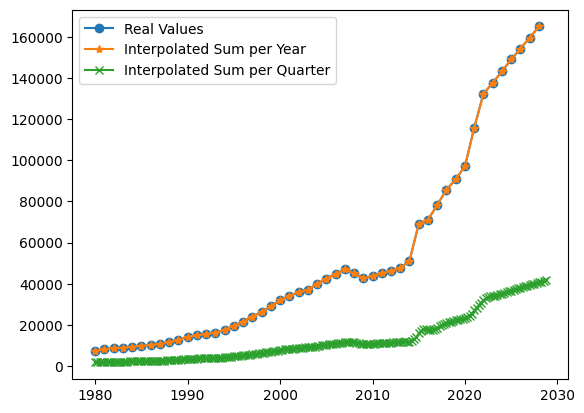

In [ ]:
x = gdp_values['Year'].astype(float)
y = gdp_values['VALUE'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x), fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
gdp_values = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE': fixed_quarter_y,
})

gdp_values.sample(5)

Quarter         VALUE
12   1983-Q1   2201.583329
156  2019-Q1  22299.339557
79   1999-Q4   7560.532947
49   1992-Q2   3893.629827
7    1981-Q4   2106.748456

## Population

In [ ]:
dataset_analysis(population)
population.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Population (Millions of people)' '1980' '1981' '1982' '1983' '1984'
 '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'
 '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 3.427 3.47 3.507 3.531 3.556 3.567 3.568 3.574 3.558 3.536
 3.533 3.553 3.582 3.601 3.613 3.629 3.654 3.692 3.731 3.774 3.829 3.889
 3.956 4.021 4.1 4.2 4.321 4.445 4.516 4.547 4.568 4.585 4.605 4.631 4.667
 4.714 4.771 4.825 4.886 4.949 4.992 5.037 5.165 5.252 5.336 5.395 5.454
 5.514 5.575]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


index    0        1    2            3
0  Population (Millions of people)  NaN  Ireland  NaN  Â©IMF, 2023
1                             1980  NaN    3.427  NaN          NaN
2                             1981  NaN     3.47  NaN          NaN
3                             1982  NaN    3.507  NaN          NaN
4                             1983  NaN    3.531  NaN          NaN

In [ ]:
# Drop first row
population = population.drop(0)

# Column names
population.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
population = population[['Year', 'VALUE']]

# Unit is Millions of people
population['VALUE'] = population['VALUE'] * 1000000

# Change column type
population['Year'] = population['Year'].astype(int)
population['VALUE'] = population['VALUE'].astype(int)

population.sample(5)

Year    VALUE
41  2020  4992000
18  1997  3692000
38  2017  4825000
16  1995  3629000
1   1980  3427000

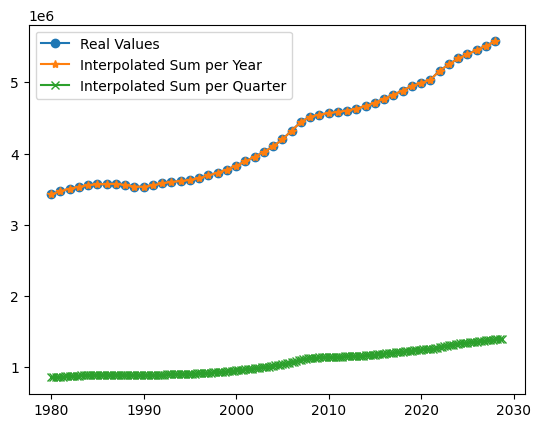

In [ ]:
x = population['Year'].astype(float)
y = population['VALUE'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x), fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
population = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE': fixed_quarter_y,
})
population['VALUE'] = population['VALUE'].astype(int)

population.sample(5)

Quarter    VALUE
52   1993-Q1   898848
79   1999-Q4   948175
124  2011-Q1  1144634
138  2014-Q3  1167943
29   1987-Q2   893779

## Inflation rate

In [ ]:
dataset_analysis(infliation)
infliation.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Inflation rate, average consumer prices (Annual percent change)' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020'
 '2021' '2022' '2023' '2024' '2025' '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 18.3 20.2 17.2 10.4 8.6 5.5 3.0 3.2 2.2 4.0 3.4 3.1 1.4 2.4 2.5
 1.3 2.1 5.3 4.7 2.3 2.7 2.9 -1.7 -1.6 1.2 1.9 0.5 0.3 0.0 -0.2 0.7 0.9
 -0.5 8.1 5.2 2.0]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


index    0        1    2  \
0  Inflation rate, average consumer prices (Annua...  NaN  Ireland  NaN   
1                                               1980  NaN     18.3  NaN   
2                                               1981  NaN     20.2  NaN   
3                                               1982  NaN     17.2  NaN   
4                                               1983  NaN     10.4  NaN   

             3  
0  Â©IMF, 2023  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# Drop first row
infliation = infliation.drop(0)

# Column names
infliation.columns = ['Year', 'empty1', 'VALUE0', 'empty2', 'empty3']

# Filter columns
infliation = infliation[['Year', 'VALUE0']]

# Change column type
infliation['Year'] = infliation['Year'].astype(int)
infliation['VALUE0'] = infliation['VALUE0'].astype(float)

infliation.sample(5)

Year  VALUE0
18  1997     1.3
13  1992     3.1
40  2019     0.9
17  1996     2.2
31  2010    -1.6

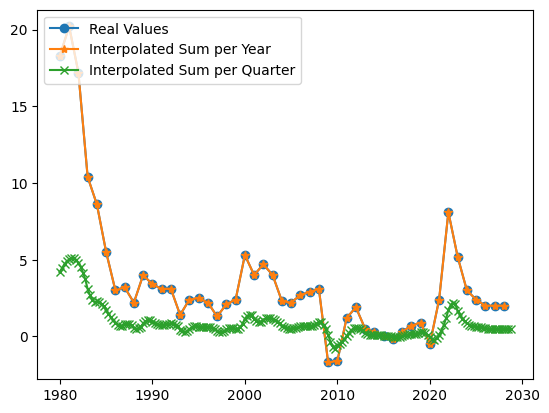

In [ ]:
x = infliation['Year'].astype(float)
y = infliation['VALUE0'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x), fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
infliation = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE0': fixed_quarter_y,
})

infliation.sample(5)

Quarter    VALUE0
47   1991-Q4  0.803763
13   1983-Q2  2.685212
70   1997-Q3  0.301789
107  2006-Q4  0.687942
75   1998-Q4  0.545619

In [ ]:
# Create list per quarter and value (assuming 1980 was 1000)
infliation_based = []
last_based_value = 1000
for qy in fixed_quarter_y:
  infliation_based.append(last_based_value)
  last_based_value += last_based_value * qy / 100

infliation['VALUE1'] = infliation_based
infliation.sample(5)

Quarter    VALUE0       VALUE1
157  2019-Q2  0.281559  4373.810793
55   1993-Q4  0.330474  2763.518479
174  2023-Q3  1.160467  5008.993230
93   2003-Q2  1.060661  3665.319824
142  2015-Q3  0.000000  4326.641441

## Unemployment percent

In [ ]:
dataset_analysis(unemployment)
unemployment.head()

Dataset Shape: (50, 5)
Dataset number of null values: 149
Dataset Columns:
	Column: index, Not Numeric, Values: ['Unemployment rate (Percent)' '1980' '1981' '1982' '1983' '1984' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005'
 '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025'
 '2026' '2027' '2028']
	Column: 0, Not Numeric, Values: [nan]
	Column: 1, Not Numeric, Values: ['Ireland' 'no data' 17.7 18.1 18.8 18.4 17.9 17.2 19.0 16.3 16.7 15.1
 14.1 11.8 9.9 7.6 5.9 4.4 4.2 4.7 4.9 4.8 4.6 5.0 6.8 12.7 14.6 15.4 15.5
 13.8 11.9 8.4 5.8 6.3 4.5 4.1]
	Column: 2, Not Numeric, Values: [nan]
	Column: 3, Not Numeric, Values: ['Â©IMF, 2023' nan]


index    0        1    2            3
0  Unemployment rate (Percent)  NaN  Ireland  NaN  Â©IMF, 2023
1                         1980  NaN  no data  NaN          NaN
2                         1981  NaN  no data  NaN          NaN
3                         1982  NaN  no data  NaN          NaN
4                         1983  NaN  no data  NaN          NaN

In [ ]:
# Drop first row
unemployment = unemployment.drop(0)

# Column names
unemployment.columns = ['Year', 'empty1', 'VALUE', 'empty2', 'empty3']

# Filter columns
unemployment = unemployment[['Year', 'VALUE']]

# Filter down that has data
unemployment = unemployment[unemployment['VALUE'] != 'no data']

# Change column type
unemployment['Year'] = unemployment['Year'].astype(int)
unemployment['VALUE'] = unemployment['VALUE'].astype(float)

unemployment.sample(5)

Year  VALUE
25  2004    4.8
10  1989   17.9
27  2006    4.8
26  2005    4.6
37  2016    8.4

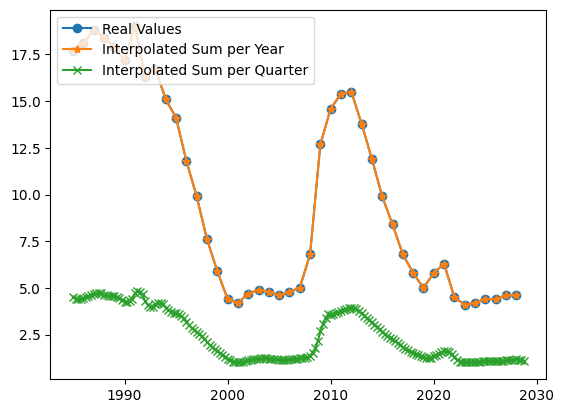

In [ ]:
x = unemployment['Year'].astype(float)
y = unemployment['VALUE'].astype(float)
interpolater = scipy.interpolate.CubicSpline(x + 0.5, y / 12)

per_month_x = [yrx + i/12 for yrx in list(x) for i in range(12)]
per_month_y = [float(interpolater(pmx)) for pmx in per_month_x]

interpolated_year = [sum(per_month_y[i:i+12]) for i in range(0, len(per_month_y), 12)]
interpolate_ratio = [real_value / interpolated_value for real_value, interpolated_value in zip(list(y) + [interpolated_year[-1]], interpolated_year)]

fixed_per_month_y = [interpolate_ratio[i//12] * pmy for i, pmy in enumerate(per_month_y)]
fixed_interpolated_year = [sum(fixed_per_month_y[i:i+12]) for i in range(0, len(fixed_per_month_y), 12)]
fixed_quarter_x = [yrx + i/4 for yrx in list(x) for i in range(4)]
fixed_quarter_y = [sum(fixed_per_month_y[i:i+3]) for i in range(0, len(fixed_per_month_y), 3)]

plt.plot(x, y, '-o', label='Real Values')
plt.plot(list(x), fixed_interpolated_year, '-*', label='Interpolated Sum per Year')
plt.plot(fixed_quarter_x, fixed_quarter_y, '-x', label='Interpolated Sum per Quarter')
plt.legend(loc="upper left")
plt.show()

In [ ]:
unemployment = pd.DataFrame({
    'Quarter': ['%d-Q%d' % (yrx, i+1) for yrx in list(x) for i in range(4)],
    'VALUE': fixed_quarter_y,
})

unemployment.sample(5)

Quarter     VALUE
70   2002-Q3  1.192490
132  2018-Q1  1.539692
112  2013-Q1  3.633259
164  2026-Q1  1.096497
162  2025-Q3  1.106144

## Merging fixed datasets into single dataset

In [ ]:
# Property sales already have Quarter and County columns, using it as base merged dataset
merged_dataset = property_sales.copy()

merged_dataset.sample(5)

Quarter   County  SaleCount  Price_min     Price_mean  Price_max  \
254  2012-Q2    Sligo         81      13333  109399.876543     407000   
883  2018-Q2  Wicklow        387      10000  332422.558140    1465000   
810  2017-Q4  Donegal        378      20000  129421.357143    2700000   
736  2017-Q1  Kildare        590       7700  243267.313559    2394950   
313  2013-Q1    Cavan         83      20000   87559.518072     350000   

     Price_median  Price_25p  Price_75p  Price_90p  
254       97000.0    65000.0  140000.00   168500.0  
883      287000.0   211601.5  410548.00   577000.0  
810      115000.0    72125.0  152088.50   215000.0  
736      236341.0   146000.0  292664.75   385500.0  
313       74889.0    41250.0  119750.00   169000.0

In [ ]:
merged_dataset = pd.merge(merged_dataset, immigrants, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE': 'Immigrants'})

merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
47   2010-Q2  Tipperary        126      59000  168286.857143     470000   
372  2013-Q3    Kildare        372       6500  195681.577957    2650000   
303  2012-Q4   Monaghan         56      21000  115519.035714     330000   
153  2011-Q2  Westmeath         98      22250  143323.836735     650000   
404  2013-Q4      Louth        256       8333  136836.421875    1900000   

     Price_median  Price_25p  Price_75p  Price_90p    Immigrants  
47       152500.0  113500.00   210000.0   262750.0   9951.848907  
372      165000.0  111973.75   236250.0   344950.0  15846.233504  
303       97500.0   66000.00   148500.0   197000.0  14780.967164  
153      128089.5   80000.00   176005.5   229900.0  13201.351492  
404      117500.0   72875.00   175750.0   232250.0  16036.085475

In [ ]:
merged_dataset = pd.merge(merged_dataset, private_households, how='left', on=['Quarter', 'County'])
merged_dataset = merged_dataset.rename(columns={'VALUE': 'PrivateHouseholds'})

merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
22    2010-Q1  Waterford         98      18000  190048.918367     600000   
1344  2022-Q4     Offaly        213      10000  209238.943662     500000   
756   2017-Q2      Clare        282      10157  227481.152482   23070000   
295   2012-Q4   Kilkenny        167       6000  139323.874251     450000   
155   2011-Q2    Wicklow        128       7618  249657.406250     900000   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
22        175000.0   126250.0   230000.0   295000.0   8233.574651   
1344      216134.0   153000.0   255000.0   324317.0  31497.316237   
756       135000.0    80000.0   191625.0   264450.0  23690.419229   
295       123500.0    83700.0   180000.0   236620.8  14780.967164   
155       219000.0   146968.5   305000.0   437500.0  13201.351492   

      PrivateHouseholds  
22         10586.054545  
1344        7263.819320  
756        10980.671875  
295         8511.430114  
155        11946.537366

In [ ]:
merged_dataset = pd.merge(merged_dataset, persons_private_households, how='left', on=['Quarter', 'County'])
merged_dataset = merged_dataset.rename(columns={'VALUE': 'PersonsPrivateHouseholds'})

merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
246   2012-Q2   Limerick        182       7000  144568.719780    1780000   
520   2015-Q1     Carlow        109      35000  128668.018349     800000   
48    2010-Q2  Waterford         98      18500  173879.459184     460000   
1074  2020-Q2    Kildare        422      10000  313593.075829   13053375   
597   2015-Q3    Wicklow        340      15000  301457.044118    1800000   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
246       116000.0    60000.0  183000.00   244500.0  14155.103307   
520       117000.0    75000.0  155000.00   210400.0  18171.517930   
48        172300.5    94250.0  224917.25   278250.0   9951.848907   
1074      264500.0   207667.0  332001.75   409969.1  24757.114878   
597       250000.0   174500.0  365625.00   536500.0  19289.642896   

      PrivateHouseholds  PersonsPrivateHouseholds  
246        17451.063920              47028.801136  
520         5073.445455              14000.383333  
48         10583.509517              28121.913778  
1074       19864.309044              59426.668750  
597        12239.262500              35050.787500

In [ ]:
merged_dataset = pd.merge(merged_dataset, household_values, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE': 'HouseholdValues'})

merged_dataset.sample(5)

Quarter   County  SaleCount  Price_min     Price_mean  Price_max  \
686   2016-Q3    Laois        182      10000  243979.994505   20800000   
270   2012-Q3    Laois        101      11500   94623.980198     272500   
706   2016-Q4  Donegal        463      12000  107284.347732     900000   
1100  2020-Q3  Kildare        648      17000  302537.350309     825000   
1136  2020-Q4   Offaly        243      15875  172432.572016     550000   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
686       125000.0    80000.0  159500.00   219820.0  20778.408714   
270        80000.0    45000.0  125000.00   184000.0  14435.169049   
706        92511.0    59123.0  135000.00   190000.0  21620.777494   
1100      298250.0   237174.5  362049.75   423895.4  23708.469398   
1136      165000.0   120000.0  212500.00   260800.0  22032.864514   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  
686         7285.551072              20913.045234        13.053779  
270         7070.206250              20173.242614        24.240232  
706        14658.393849              39363.533583        12.786422  
1100       19975.208523              59718.150000         8.692453  
1136        7128.927557              20248.314631         8.427054

In [ ]:
merged_dataset = pd.merge(merged_dataset, gdp_growth, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE0': 'GDPGrowth', 'VALUE1': 'GDPGrowthBased'})

merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
1416  2023-Q3   Limerick        594      10000  256283.183502    1200000   
1227  2021-Q4     Dublin       5116       9550  609573.356724  107488987   
302   2012-Q4      Meath        297       8750  174221.915825    1318000   
932   2018-Q4  Waterford        511      10000  183663.414873    1700000   
432   2014-Q1      Meath        227      30000  176294.656388     550000   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
1416      235000.0   163500.0  322271.25   406700.0  36307.363396   
1227      382500.0   295000.0  555000.00   841897.5  19022.530928   
302       145000.0   108100.0  215000.00   314300.0  14780.967164   
932       160000.0   113750.0  210000.00   285000.0  23871.912391   
432       150000.0   105363.5  232500.00   311022.0  16084.510734   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  \
1416       19589.096591              52783.977273         7.722483   0.363604   
1227      102404.237689             271509.586032         6.993035   3.921648   
302        15592.339820              46672.357292        23.842625   0.000000   
932        11277.972396              29571.704688         9.836568   1.610877   
432        15711.940909              47285.300000        21.787495   0.693615   

      GDPGrowthBased  
1416     7745.503415  
1227     6732.167550  
302      3283.566910  
932      5327.829828  
432      3316.517743

In [ ]:
merged_dataset = pd.merge(merged_dataset, gdp_values, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE': 'GDPValues'})

merged_dataset.sample(5)

Quarter   County  SaleCount  Price_min     Price_mean  Price_max  \
720   2016-Q4   Offaly        204      20000  119576.705882    1145000   
976   2019-Q2    Louth        449       7000  218731.525612    1800000   
345   2013-Q2    Kerry        201      15950  132504.104478     950000   
1330  2022-Q4  Donegal        416      10000  201268.290865    2436922   
34    2010-Q2  Kildare        262      35770  237564.454198     945000   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
720       103500.0   68000.00   142262.0   207800.0  21620.777494   
976       219383.0  168067.00   251101.0   300000.0  24095.796220   
345       105000.0   70000.00   180000.0   235000.0  15580.142990   
1330      180000.0  105000.00   249541.0   343500.0  31497.316237   
34        223029.5  168070.25   284375.0   367250.0   9951.848907   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  \
720         6854.118708              19488.328823        12.786422   0.044874   
976        11825.775000              33244.128125         9.308269   1.303629   
345        13403.796875              35130.617188        23.215122   0.194359   
1330       15521.594322              41330.086297         6.436060   1.413375   
34         17679.214347              51836.668750        28.204985   0.115594   

      GDPGrowthBased     GDPValues  
720      4574.067727  18046.628314  
976      5491.970399  22579.537095  
345      3287.269106  11949.259868  
1330     7540.260159  33997.999188  
34       3195.133642  10888.206584

In [ ]:
merged_dataset = pd.merge(merged_dataset, population, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE': 'Population'})

merged_dataset.sample(5)

Quarter    County  SaleCount  Price_min     Price_mean  Price_max  \
999   2019-Q3   Leitrim         94      15000  122254.553191    1234513   
1162  2021-Q1    Offaly         35      60000  198122.742857     375000   
382   2013-Q3    Offaly         84      20000  107129.892857     350000   
1317  2022-Q3  Monaghan        132      25000  248029.348485    5836560   
1149  2021-Q1    Dublin       3699       6900  509243.760205   38094573   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
999       103750.0    75000.0  145750.00   194400.0  24373.251057   
1162      175000.0   121875.0  265000.00   350000.0  19181.858495   
382        87395.0    59125.0  146250.00   187000.0  15846.233504   
1317      195000.0   139000.0  263329.25   341750.0  28486.097139   
1149      361233.0   272500.0  510000.00   765000.0  19181.858495   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  \
999         3251.475379               8284.684659         9.135106   1.174726   
1162        7148.469697              20303.280303         8.017969   3.211751   
382         6741.066288              19191.839962        22.839242   0.279300   
1317        5748.314119              16129.448032         6.395575   1.957126   
1149      101283.848485             269027.174242         8.017969   3.211751   

      GDPGrowthBased     GDPValues  Population  
999      5563.565305  22826.248135     1239196  
1162     6038.332356  27034.219525     1252066  
382      3293.658207  11960.862935     1158609  
1317     7395.520503  33545.302543     1295651  
1149     6038.332356  27034.219525     1252066

In [ ]:
merged_dataset = pd.merge(merged_dataset, infliation, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE0': 'Infliation', 'VALUE1': 'InfliationBased'})

merged_dataset.sample(5)

Quarter   County  SaleCount  Price_min     Price_mean  Price_max  \
857   2018-Q1  Wicklow        356      20000  340560.620787    2400000   
157   2011-Q3    Cavan         86      18000  125606.686047     350000   
311   2012-Q4  Wicklow        287      18000  248892.609756    7225000   
1289  2022-Q2     Mayo        397       8666  179429.858942     882500   
1279  2022-Q2   Dublin       4322      10000  598866.286441  107488987   

      Price_median  Price_25p  Price_75p  Price_90p    Immigrants  \
857       285000.0  220000.00   400000.0   562592.5  24158.133915   
157       110066.0   82194.25   162250.0   200000.0  13575.837071   
311       185000.0  129250.00   265000.0   387600.0  14780.967164   
1289      160000.0  113000.00   222000.0   306400.0  25348.155803   
1279      395000.0  305000.00   550660.0   820000.0  25348.155803   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  \
857        12619.283333              36132.100000        10.660168   2.411526   
157         6459.783804              18167.742604        26.322775   0.203088   
311        12001.948958              34186.909375        23.842625   0.000000   
1289       13004.265842              33716.024141         6.486447   2.542768   
1279      102588.046944             271922.091559         6.486447   2.542768   

      GDPGrowthBased     GDPValues  Population  Infliation  InfliationBased  
857      5001.467625  20829.704067     1215503    0.129162      4330.961634  
157      3273.192336  11303.824435     1146764    0.409843      4172.343646  
311      3283.566910  11722.812171     1153383    0.388511      4275.576537  
1289     7212.132678  32863.957594     1288052    2.058368      4561.530170  
1279     7212.132678  32863.957594     1288052    2.058368      4561.530170

In [ ]:
merged_dataset = pd.merge(merged_dataset, unemployment, how='left', on='Quarter')
merged_dataset = merged_dataset.rename(columns={'VALUE': 'Unemployment'})

merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
1010  2019-Q3  Waterford        432      17500  189601.509259    1910132   
992   2019-Q3    Donegal        417      10000  130662.258993    1802000   
414   2013-Q4    Wexford        347      10000  118712.302594     710000   
1231  2021-Q4   Kilkenny        299      20250  277746.511706    4250000   
82    2010-Q4    Donegal        191      18577  140816.376963     715000   

      Price_median  Price_25p  Price_75p  Price_90p  ...  PrivateHouseholds  \
1010      175000.0   115000.0   225000.0   305000.0  ...       11412.097538   
992       120000.0    70000.0   164000.0   222300.0  ...       15016.824811   
414       105000.0    65000.0   150000.0   208800.0  ...       13314.596875   
1231      229000.0   175000.0   309200.0   420000.0  ...        9173.789205   
82        125000.0    89500.0   169818.5   246242.0  ...       14497.291903   

      PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  GDPGrowthBased  \
1010              29919.940341         9.135106   1.174726     5563.565305   
992               40059.084280         9.135106   1.174726     5563.565305   
414               36437.510937        22.378874   0.413592     3302.857405   
1231              25517.026610         6.993035   3.921648     6732.167550   
82                39855.071733        27.372286   0.927569     3221.064407   

         GDPValues  Population  Infliation  InfliationBased  Unemployment  
1010  22826.248135     1239196    0.222121      4386.125635      1.229183  
992   22826.248135     1239196    0.222121      4386.125635      1.229183  
414   11945.751811     1160666    0.060835      4311.063201      3.269077  
1231  30869.677914     1268422    1.173102      4432.669524      1.476367  
82    11087.140140     1143705   -0.168803      4168.501701      3.725426  

[5 rows x 21 columns]

## Checking merged dataset

In [ ]:
merged_dataset.sample(5)

Quarter     County  SaleCount  Price_min     Price_mean  Price_max  \
611   2015-Q4   Longford        110      10000   81447.163636     220000   
724   2016-Q4  Waterford        445      11668  141559.337079    2000000   
392   2013-Q4      Clare        212      19000  111305.740566     455000   
1176  2021-Q2     Galway        676       7000  255702.748521    3215859   
983   2019-Q2  Tipperary        437      10000  146687.697941    3000000   

      Price_median  Price_25p  Price_75p  Price_90p  ...  PrivateHouseholds  \
611        65000.0    37250.0  110783.00   160000.0  ...        3770.769176   
724       130000.0    70000.0  175000.00   230000.0  ...       10933.122512   
392        86000.0    60000.0  146250.00   214700.0  ...       10725.696875   
1176      230000.0   152375.0  314487.75   400914.0  ...        7651.259659   
983       131000.0    76000.0  175000.00   245000.0  ...       15150.865625   

      PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  GDPGrowthBased  \
611               10166.897491        12.546281   5.002869     4314.839006   
724               28710.693344        12.786422   0.044874     4574.067727   
392               28948.567187        22.378874   0.413592     3302.857405   
1176              19989.380398         7.669805   3.803142     6232.268572   
983               40531.795312         9.308269   1.303629     5491.970399   

         GDPValues  Population  Infliation  InfliationBased  Unemployment  
611   18210.928635     1183572    0.000000      4326.641441      2.317393  
724   18046.628314     1197945   -0.022056      4318.947011      1.952180  
392   11945.751811     1160666    0.060835      4311.063201      3.269077  
1176  28338.573278     1255537    0.375267      4383.671014      1.626356  
983   22579.537095     1235636    0.281559      4373.810793      1.238200  

[5 rows x 21 columns]

In [ ]:
dataset_analysis(merged_dataset)

Dataset Shape: (1451, 21)
Dataset number of null values: 0
Dataset Columns:
	Column: Quarter, Not Numeric, Values: ['2010-Q1' '2010-Q2' '2010-Q3' '2010-Q4' '2011-Q1' '2011-Q2' '2011-Q3'
 '2011-Q4' '2012-Q1' '2012-Q2' '2012-Q3' '2012-Q4' '2013-Q1' '2013-Q2'
 '2013-Q3' '2013-Q4' '2014-Q1' '2014-Q2' '2014-Q3' '2014-Q4' '2015-Q1'
 '2015-Q2' '2015-Q3' '2015-Q4' '2016-Q1' '2016-Q2' '2016-Q3' '2016-Q4'
 '2017-Q1' '2017-Q2' '2017-Q3' '2017-Q4' '2018-Q1' '2018-Q2' '2018-Q3'
 '2018-Q4' '2019-Q1' '2019-Q2' '2019-Q3' '2019-Q4' '2020-Q1' '2020-Q2'
 '2020-Q3' '2020-Q4' '2021-Q1' '2021-Q2' '2021-Q3' '2021-Q4' '2022-Q1'
 '2022-Q2' '2022-Q3' '2022-Q4' '2023-Q1' '2023-Q2' '2023-Q3' '2023-Q4']
	Column: County, Not Numeric, Values: ['Carlow' 'Cavan' 'Clare' 'Cork' 'Donegal' 'Dublin' 'Galway' 'Kerry'
 'Kildare' 'Kilkenny' 'Laois' 'Leitrim' 'Limerick' 'Longford' 'Louth'
 'Mayo' 'Meath' 'Monaghan' 'Offaly' 'Roscommon' 'Sligo' 'Tipperary'
 'Waterford' 'Westmeath' 'Wexford' 'Wicklow']
	Column: SaleCount, Numer

In [ ]:
merged_dataset.isna().sum()

Quarter                     0
County                      0
SaleCount                   0
Price_min                   0
Price_mean                  0
Price_max                   0
Price_median                0
Price_25p                   0
Price_75p                   0
Price_90p                   0
Immigrants                  0
PrivateHouseholds           0
PersonsPrivateHouseholds    0
HouseholdValues             0
GDPGrowth                   0
GDPGrowthBased              0
GDPValues                   0
Population                  0
Infliation                  0
InfliationBased             0
Unemployment                0
dtype: int64

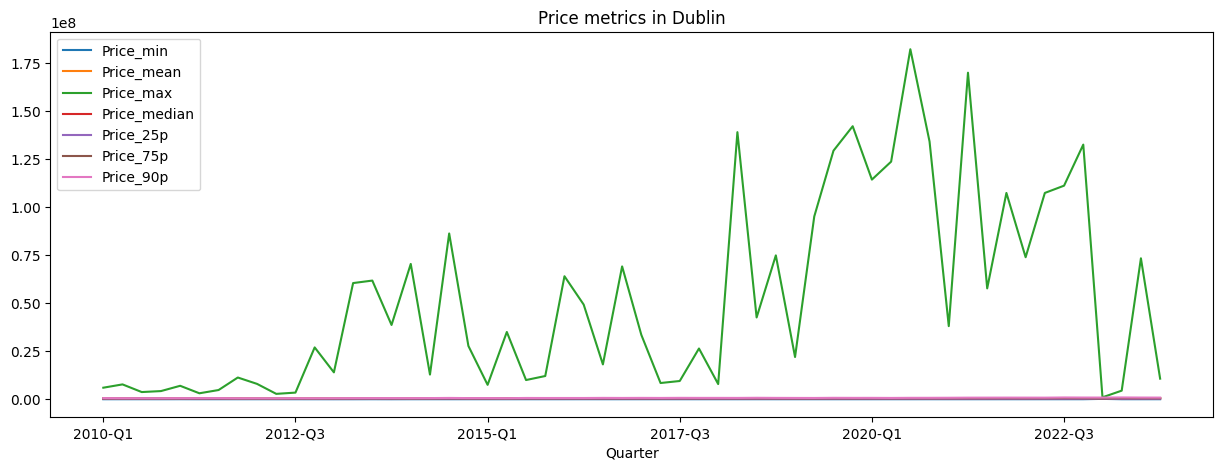

In [ ]:
dublin_county = merged_dataset[merged_dataset['County'] == 'Dublin']
price_columns = [col for col in merged_dataset.columns if col.startswith('Price_')]
dublin_county.plot(x='Quarter', y=price_columns, style='-', figsize=(15, 5), title='Price metrics in Dublin')
plt.show()

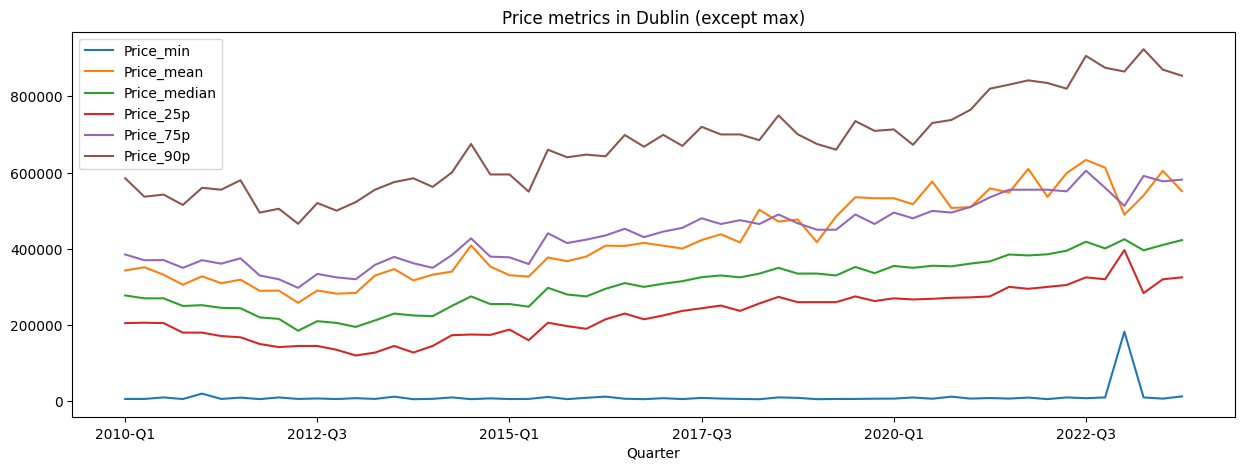

In [ ]:
dublin_county = merged_dataset[merged_dataset['County'] == 'Dublin']
price_columns = [col for col in merged_dataset.columns if col.startswith('Price_') and col != 'Price_max']
dublin_county.plot(x='Quarter', y=price_columns, style='-', figsize=(15, 5), title='Price metrics in Dublin (except max)')
plt.show()

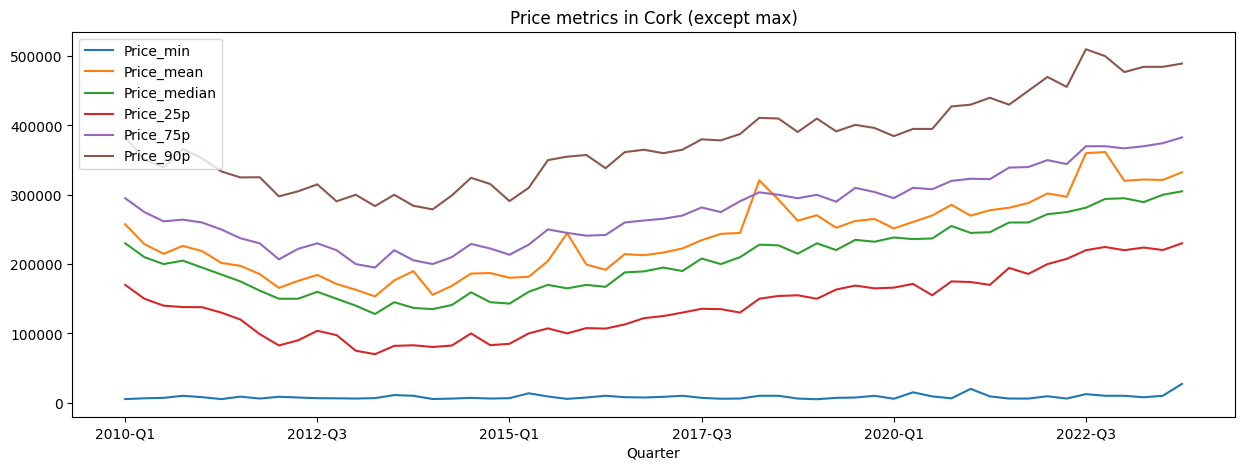

In [ ]:
cork_county = merged_dataset[merged_dataset['County'] == 'Cork']
price_columns = [col for col in merged_dataset.columns if col.startswith('Price_') and col != 'Price_max']
cork_county.plot(x='Quarter', y=price_columns, style='-', figsize=(15, 5), title='Price metrics in Cork (except max)')
plt.show()

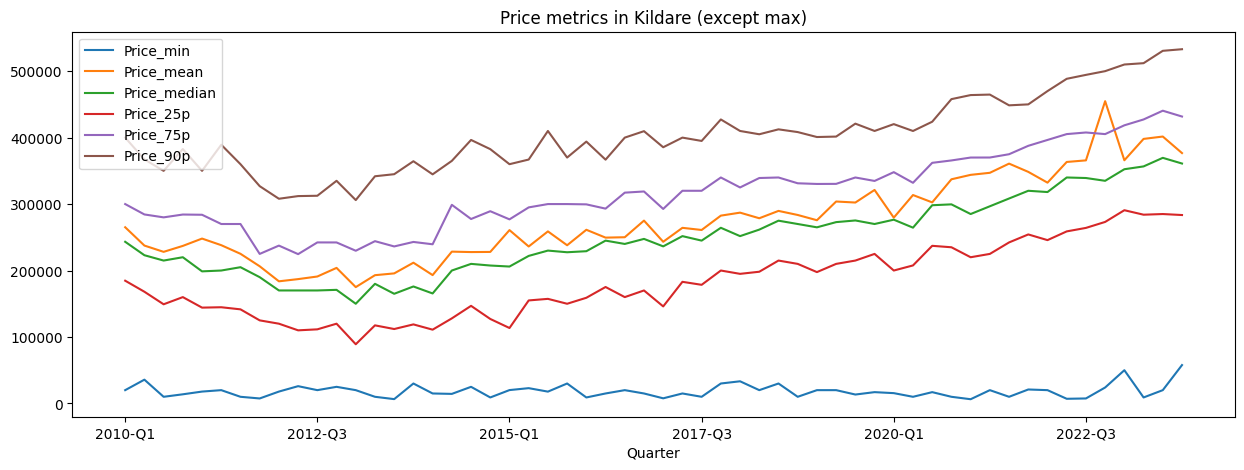

In [ ]:
kildare_county = merged_dataset[merged_dataset['County'] == 'Kildare']
price_columns = [col for col in merged_dataset.columns if col.startswith('Price_') and col != 'Price_max']
kildare_county.plot(x='Quarter', y=price_columns, style='-', figsize=(15, 5), title='Price metrics in Kildare (except max)')
plt.show()

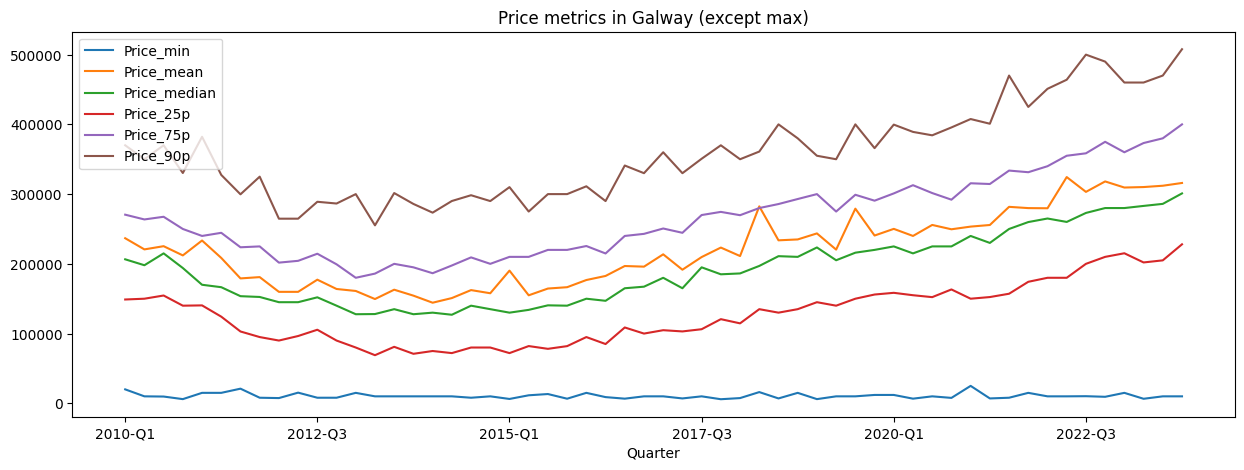

In [ ]:
galway_county = merged_dataset[merged_dataset['County'] == 'Galway']
price_columns = [col for col in merged_dataset.columns if col.startswith('Price_') and col != 'Price_max']
galway_county.plot(x='Quarter', y=price_columns, style='-', figsize=(15, 5), title='Price metrics in Galway (except max)')
plt.show()

<ipython-input-65-f2d128c95217>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_dataset.corr(), cbar=True, annot=True, square=True, fmt='.2f', linewidths=.5, ax=ax)


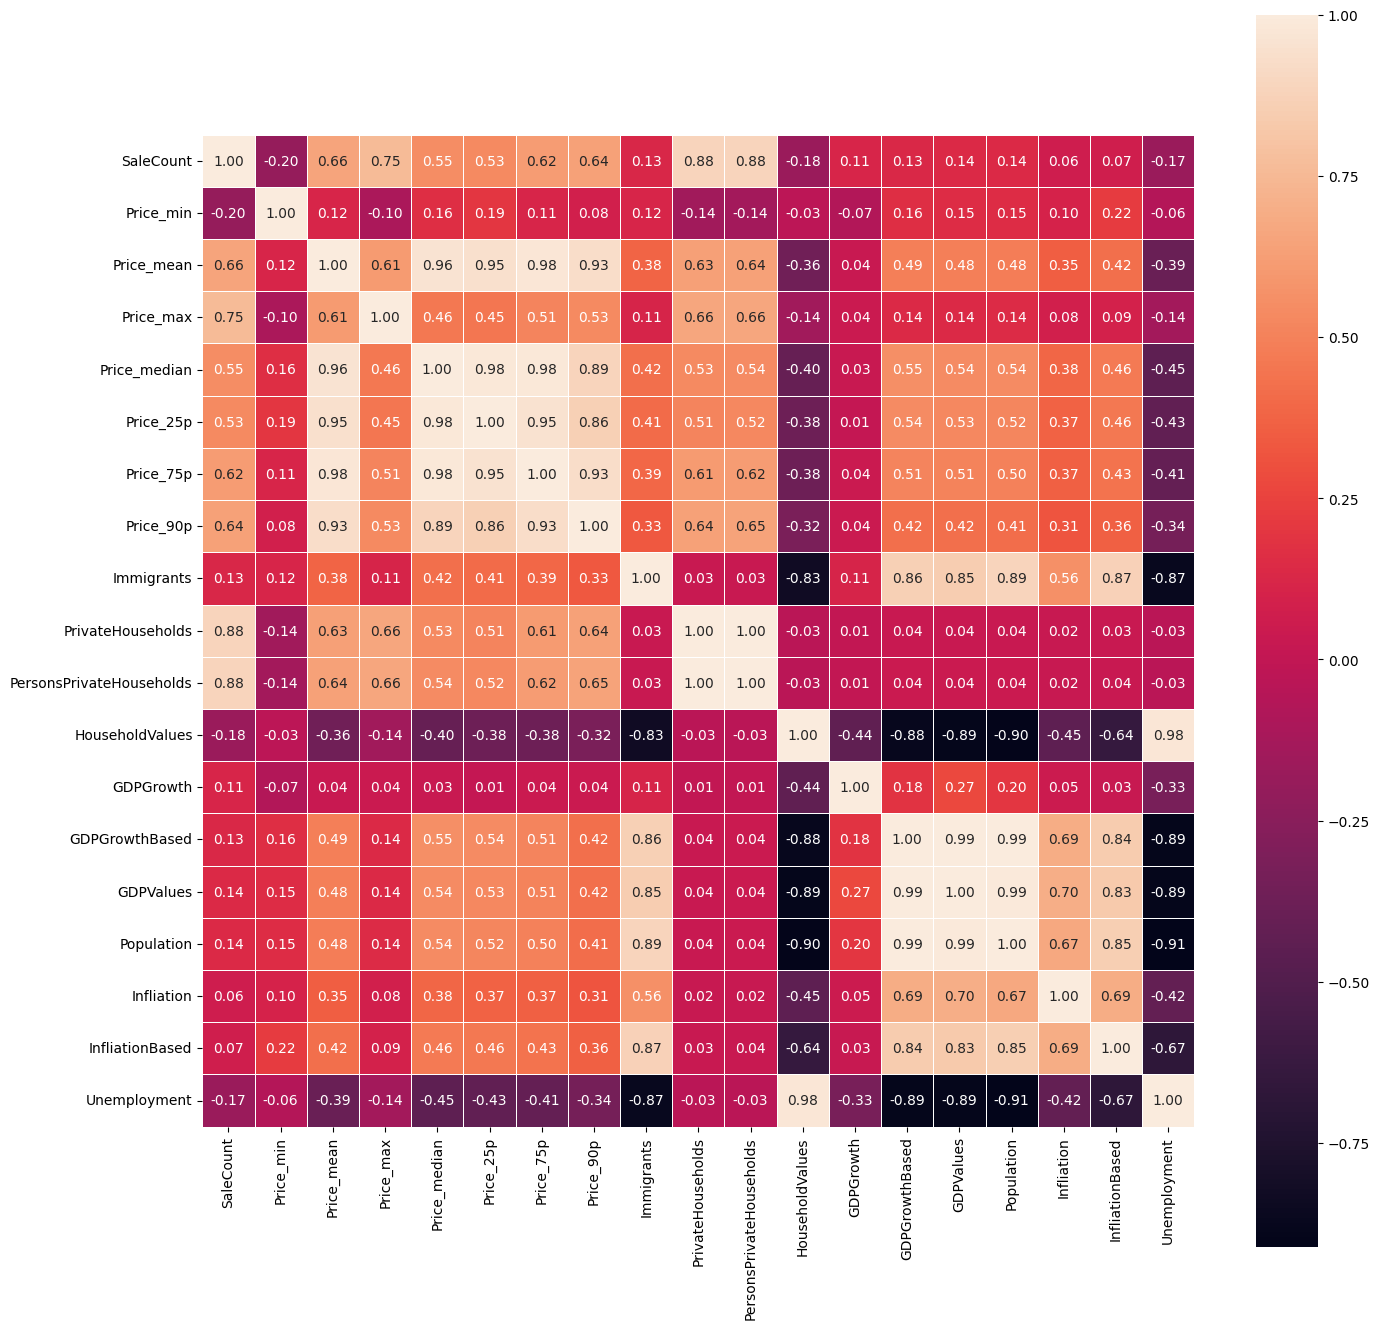

In [ ]:
# Correlation of columns
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(merged_dataset.corr(), cbar=True, annot=True, square=True, fmt='.2f', linewidths=.5, ax=ax)
plt.show()

In [ ]:
merged_dataset = merged_dataset.drop(['Price_min', 'Price_mean', 'Price_max', 'Price_25p', 'Price_75p', 'Price_90p'], axis=1)

merged_dataset.sample(5)

Quarter   County  SaleCount  Price_median    Immigrants  \
743   2017-Q1     Mayo        263       93000.0  22860.777409   
238   2012-Q2  Donegal        149       97000.0  14155.103307   
1199  2021-Q3     Cork       1619      260000.0  17886.289331   
1134  2020-Q4    Meath        941      264317.0  22032.864514   
345   2013-Q2    Kerry        201      105000.0  15580.142990   

      PrivateHouseholds  PersonsPrivateHouseholds  HouseholdValues  GDPGrowth  \
743        12316.659091              32092.590909        12.153966   1.025965   
238        14478.189631              39500.333097        24.702344   0.000000   
1199       52453.768750             142882.056250         7.319192   4.063459   
1134       17647.118608              53369.890625         8.427054   2.177161   
345        13403.796875              35130.617188        23.215122   0.194359   

      GDPGrowthBased     GDPValues  Population  Infliation  InfliationBased  \
743      4576.120294  18720.414221     1201078    0.018964      4317.994405   
238      3283.566910  11494.351821     1150512    0.520485      4233.332378   
1199     6469.290610  29642.899282     1260973    0.739708      4400.121477   
1134     5909.669320  25557.216819     1250809   -0.091697      4382.789050   
345      3287.269106  11949.259868     1156724    0.139110      4301.388776   

      Unemployment  
743       1.831368  
238       3.917644  
1199      1.578445  
1134      1.557246  
345       3.510533

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


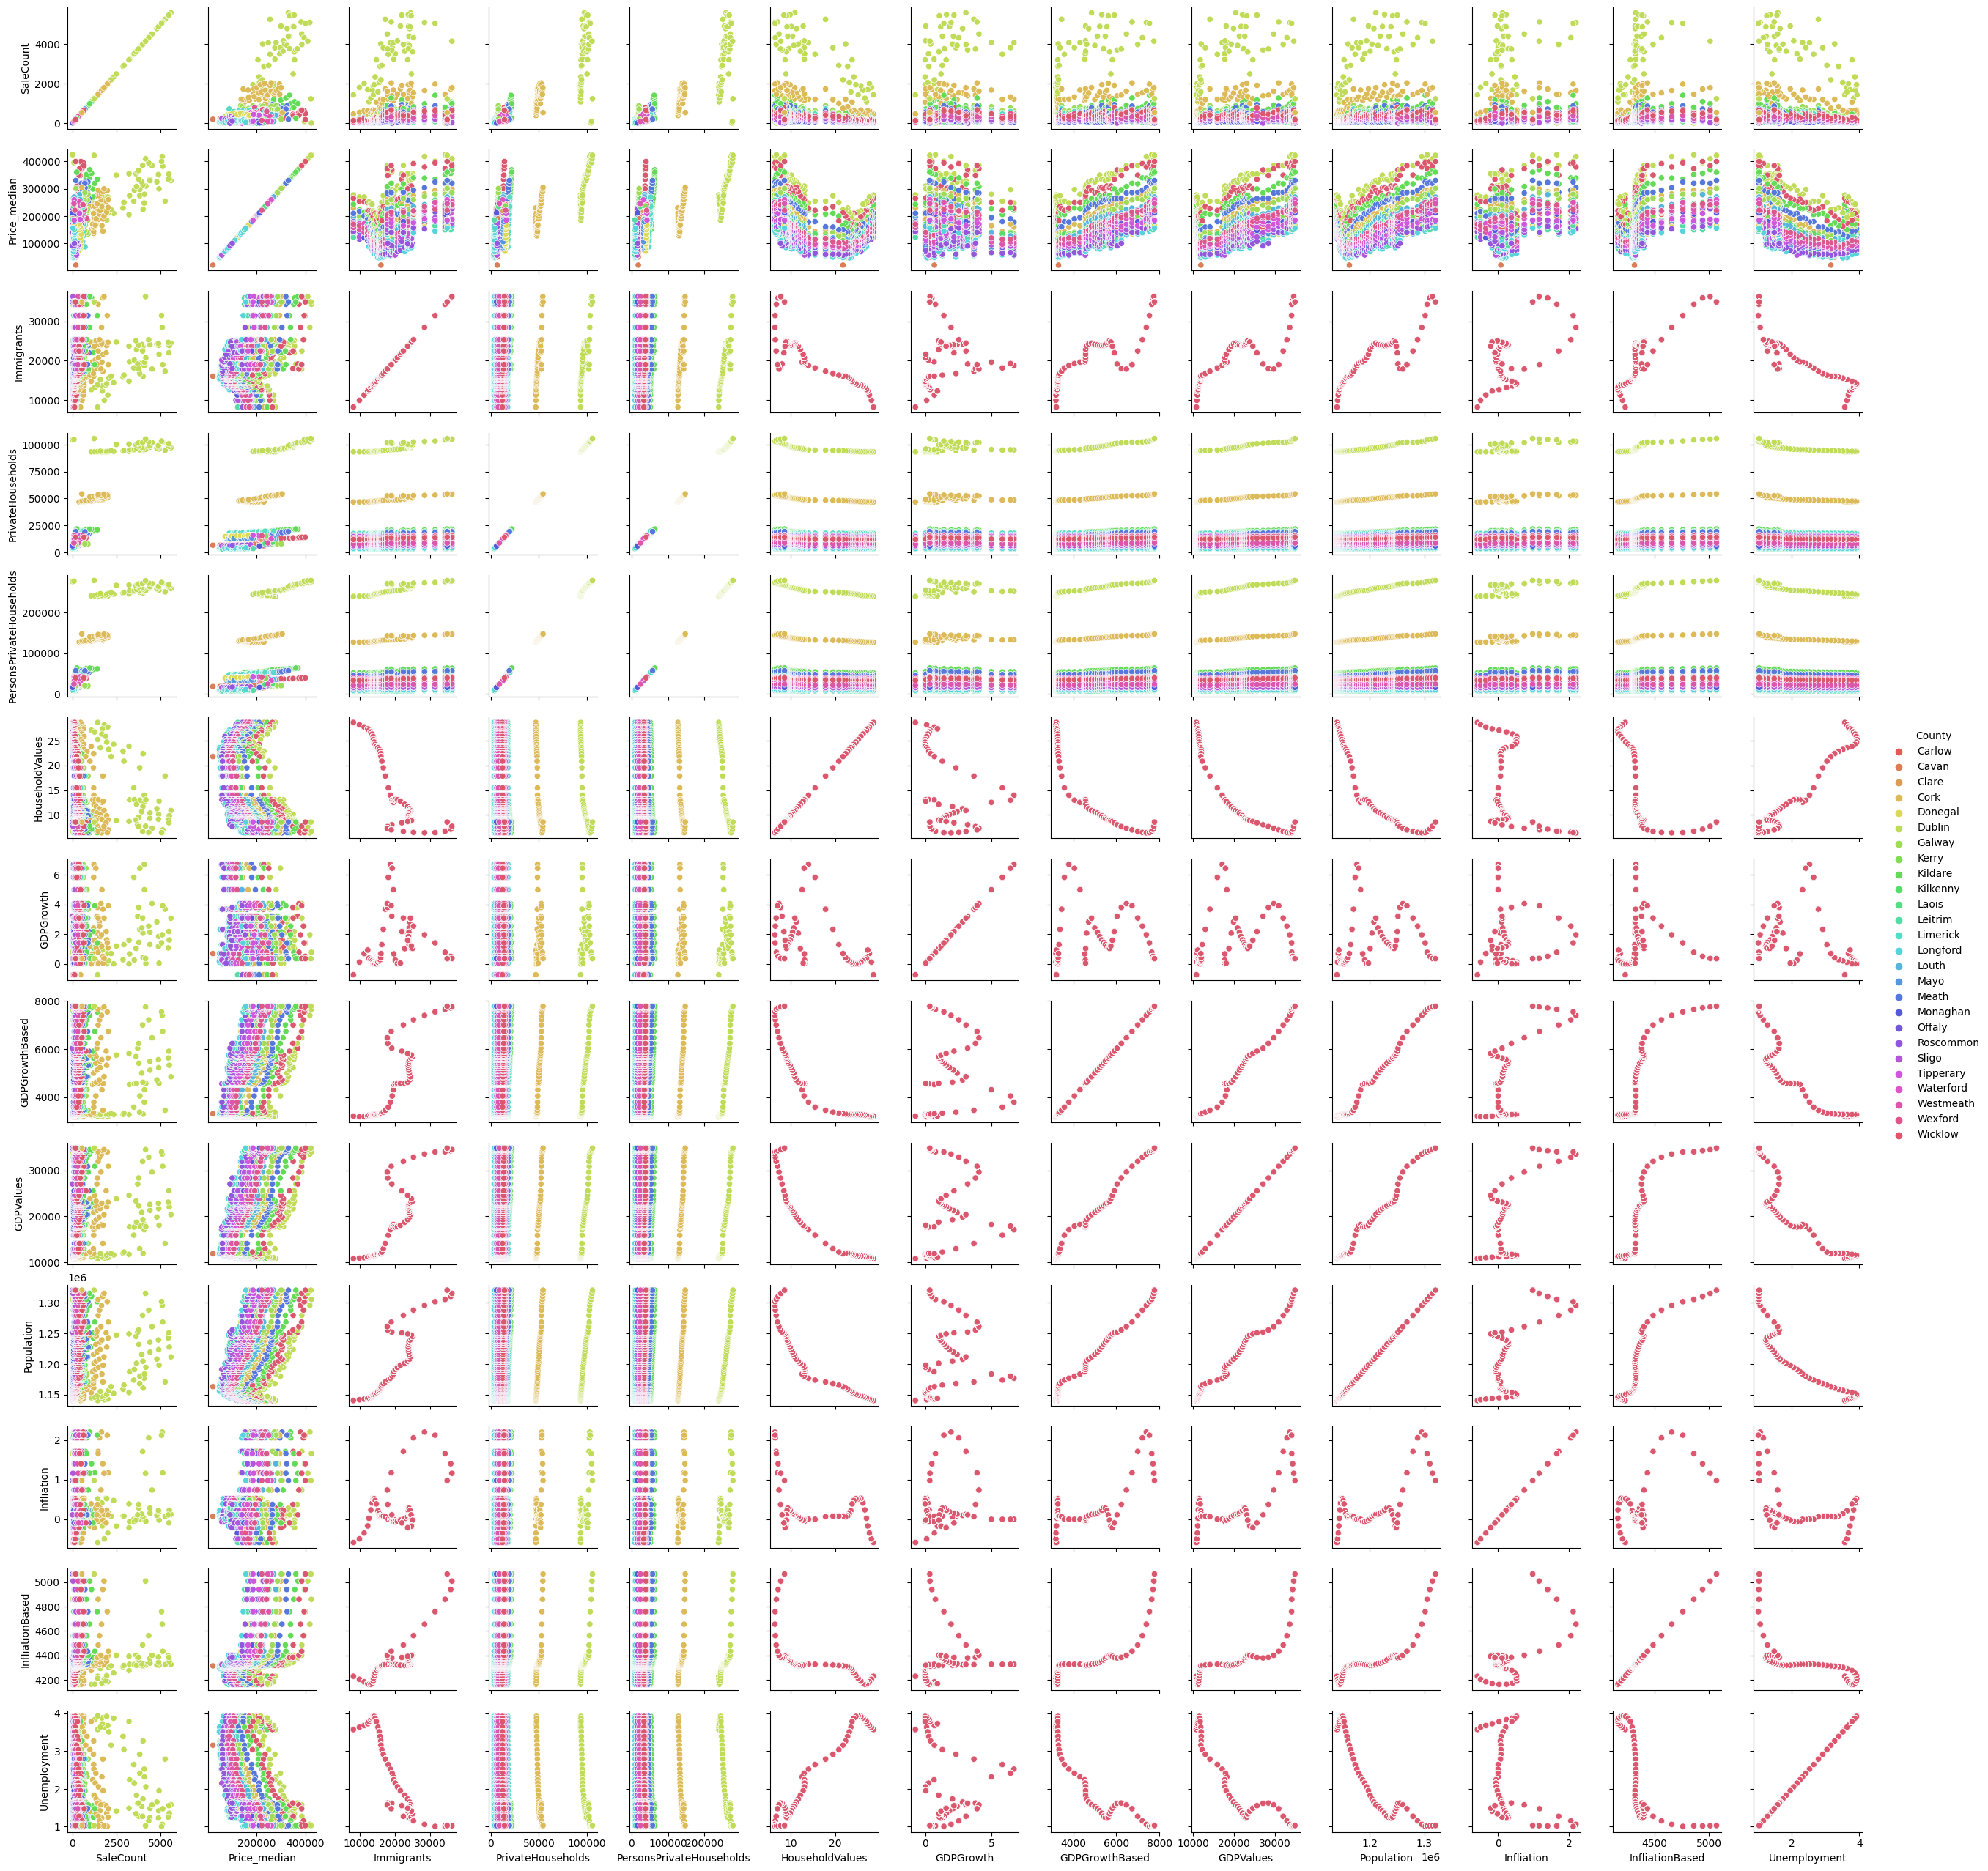

In [ ]:
# Pair-wise comparison
sns.pairplot(merged_dataset, size=2, hue='County', palette='hls', diag_kind=None)
plt.show()

In [ ]:
merged_dataset.to_csv(data_path + '/merged_dataset.csv', encoding='utf-8')